# Analysis of Presidential Speeches (U.S.)

# Creating the dataframe

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import inaugural
from string import punctuation
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk.tokenize
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('wordnet')
nltk.download('universal_tagset')
porter,lancaster,snowball = nltk.stem.PorterStemmer(),nltk.stem.LancasterStemmer(),nltk.stem.SnowballStemmer('english')
wordnet = nltk.stem.WordNetLemmatizer()

stop_words = nltk.corpus.stopwords.words('english')
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arpit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\arpit\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [2]:
df=pd.DataFrame()
df['year']=[i.split('-')[0] for i in inaugural.fileids()]
df['president']=[i.split('-')[1].split('.')[0] for i in inaugural.fileids()]
df['speech']=[' '.join(inaugural.words(fileids=i)) for i in inaugural.fileids() ]

In [4]:
len(set(df.president))

35

In [5]:
df.loc[13,'president']='W Harrison'
df.loc[25,'president']='B Harrison'
df.loc[29,'president']='T Roosevelt'
df.loc[36,'president']='F Roosevelt'
df.loc[37,'president']='F Roosevelt'
df.loc[38,'president']='F Roosevelt'
df.loc[39,'president']='F Roosevelt'
df.loc[50,'president']='GHW Bush'
df.loc[53,'president']='GW Bush'
df.loc[54,'president']='GW Bush'
df.loc[2,'president']='J Adams'
df.loc[9,'president']='JQ Adams'
df.loc[44,'president']='L Johnson'
df[df.president=='Cleveland']

,year,president,speech
24,1885,Cleveland,"Fellow citizens , in the presence of this vast..."
26,1893,Cleveland,"My Fellow citizens , in obedience of the manda..."


In [7]:
#To add the political parties of each president, I found a dataset on kaggle.
#I cleaned the Dataset and joined it with df.
#This dataset can be found at :
#https://www.kaggle.com/harshitagpt/us-presidents/data
dfparty=pd.read_csv('C:\\Users\\arpit\\OneDrive\\Desktop\\us_presidents.csv')
dfparty.head()

,Unnamed: 0,S.No.,start,end,president,prior,party,vice
0,0,1,"April 30, 1789","March 4, 1797",George Washington,Commander-in-Chief of the Continental Army ...,Nonpartisan [13],John Adams
1,1,2,"March 4, 1797","March 4, 1801",John Adams,1st Vice President of the United States,Federalist,Thomas Jefferson
2,2,3,"March 4, 1801","March 4, 1809",Thomas Jefferson,2nd Vice President of the United States,Democratic- Republican,Aaron Burr
3,3,4,"March 4, 1809","March 4, 1817",James Madison,5th United States Secretary of State (1801–...,Democratic- Republican,George Clinton
4,4,5,"March 4, 1817","March 4, 1825",James Monroe,7th United States Secretary of State (1811–...,Democratic- Republican,Daniel D. Tompkins


In [8]:
dfparty['president']=[i.split()[-1] 
                      if i.split()[-1] not in ['Roosevelt','Harrison','Adams','Johnson'] 
                      else i[0]+" "+i.split()[-1]
                      for i in dfparty['president']]

In [9]:
dfparty=dfparty[['president','party']]

In [10]:
dfparty['party']=[i if i in ['Democratic','Republican'] else 'Other' for i in dfparty['party'] ]

In [11]:
dfparty.loc[40,'president']='GHW Bush'
dfparty.loc[42,'president']='GW Bush'
dfparty.loc[5,'president']='JQ Adams'
dfparty.loc[7,'president']='VanBuren'

In [12]:
dfparty.head(2)

,president,party
0,Washington,Other
1,J Adams,Other


In [13]:
finaldf=pd.merge(df,dfparty,left_on='president',right_on='president',how='left',).drop_duplicates()

In [14]:
sentimentdf=pd.merge(df,dfparty,how='left',left_on='president',right_on='president')
sentimentdf.head()

,year,president,speech,party
0,1789,Washington,Fellow - Citizens of the Senate and of the Hou...,Other
1,1793,Washington,"Fellow citizens , I am again called upon by th...",Other
2,1797,J Adams,"When it was first perceived , in early times ,...",Other
3,1801,Jefferson,Friends and Fellow Citizens : Called upon to u...,Other
4,1805,Jefferson,"Proceeding , fellow citizens , to that qualifi...",Other


In [15]:
dfparty.head()

,president,party
0,Washington,Other
1,J Adams,Other
2,Jefferson,Other
3,Madison,Other
4,Monroe,Other


In [16]:
#exporting to a csv
finaldf.to_csv('allpresidents.csv')
sentimentdf.to_csv('presidentsentiment.csv')

# Pre-processing

In [17]:
df_year=pd.read_csv('allpresidents.csv')

In [18]:
df_year.columns

Index(['Unnamed: 0', 'year', 'president', 'speech', 'party'], dtype='object')

In [19]:
df_year.drop('Unnamed: 0',1,inplace=True)

In [20]:
df_text=pd.merge(df_year.groupby(['president'])['speech'].apply(lambda x: ','.join(x)),
                 df_year.drop('year',1),how='right',left_on='president',right_on='president')#.drop(speech_y,1)
df_text.drop('speech_y',1,inplace=True)
df_text=pd.merge(df_text,df_year.groupby('president').mean().sort_values('year'),how='left',left_on='president',
                right_on='president')
df_text=df_text.sort_values('year').drop_duplicates().reset_index().drop('index',1)

In [21]:
df_text.head()

,president,speech_x,party,year
0,Washington,Fellow - Citizens of the Senate and of the Hou...,Other,1791
1,J Adams,"When it was first perceived , in early times ,...",Other,1797
2,Jefferson,Friends and Fellow Citizens : Called upon to u...,Other,1803
3,Madison,Unwilling to depart from examples of the most ...,Other,1811
4,Monroe,I should be destitute of feeling if I was not ...,Other,1819


In [22]:
#Removing punctuation and special characters
speech,token,vocab,noun,verb,adjective, navtext, natext=[[] for i in range(8)]
for s in df_text.speech_x:
    for char in '!#$%&@?,.:;+-*/=<>"\'()[\\]X{|}~\n\t':
        s = s.replace(char, ' ')
    #tokenizing and removing stopwords
    x=[w for w in nltk.tokenize.word_tokenize(s.lower()) if w not in stop_words]
    x=[w for w in x if w not in ['u','U']]
    speech.append(' '.join(x))
    #lemmatizing
    lemm = [wordnet.lemmatize(w) for w in x]
    lemm=[w for w in lemm if w!='u']
    vocab.append(list(set(lemm)))
    #Parts of Speech Classification
    #after checking for misclassifications using parts of speech tagging, I found that universal tagset works better.
    uni_pos = nltk.pos_tag(lemm, tagset='universal')
    
    #Create seperate lists for nouns and adjectives
    word, pos = zip(*uni_pos)
    n,a,v=[],[],[]
    for i, w in enumerate(word):
        if pos[i] == 'NOUN':
            n.append(word[i])
            n=[w for w in n if n!='u']
        elif pos[i] == 'ADJ':
            a.append(word[i])
            a=[w for w in a if a!='u']
        elif pos[i] =='VERB':
            v.append(word[i])
            v=[w for w in a if a!='u']
    noun.append(len(list(set(n))))
    verb.append(len(list(set(v))))
    adjective.append(len(list(set(a))))
    navtext.append(" ".join(n)+" "+" ".join(v)+" "+" ".join(a))
    natext.append(" ".join(n)+" "+" ".join(a))    

vocabnum=[len(item) for item in vocab]

In [23]:
df_text['cleanspeech']=speech
df_text['vocab']=vocabnum
df_text['noun']=noun
df_text['adjective']=adjective
df_text['verb']=verb
df_text['vocab2']=df_text['noun']+df_text['verb']+df_text['adjective']
df_text['navtext']=navtext
df_text['natext']=natext
df_text.head()

,president,speech_x,party,year,cleanspeech,vocab,noun,adjective,verb,vocab2,navtext,natext
0,Washington,Fellow - Citizens of the Senate and of the Hou...,Other,1791,fellow citizens senate house representatives a...,521,243,120,119,482,citizen senate house representative life event...,citizen senate house representative life event...
1,J Adams,"When it was first perceived , in early times ,...",Other,1797,first perceived early times middle course amer...,662,322,180,178,680,time course america submission legislature ind...,time course america submission legislature ind...
2,Jefferson,Friends and Fellow Citizens : Called upon to u...,Other,1803,friends fellow citizens called upon undertake ...,1039,484,280,279,1043,friend fellow citizen undertake duty office co...,friend fellow citizen undertake duty office co...
3,Madison,Unwilling to depart from examples of the most ...,Other,1811,unwilling depart examples revered authority av...,735,350,203,201,754,example authority avail occasion profound impr...,example authority avail occasion profound impr...
4,Monroe,I should be destitute of feeling if I was not ...,Other,1819,destitute feeling deeply affected strong proof...,1473,662,409,409,1480,destitute proof fellow confidence office funct...,destitute proof fellow confidence office funct...


# Who has the best and worst vocabulary?

In [24]:
print("Best Vocabulary: \n", df_text[df_text['vocab2']==max(df_text['vocab2'])][['president','vocab2','party']])
print("Worst Vocabulary: \n", df_text[df_text['vocab2']==min(df_text['vocab2'])][['president','vocab2','party']])

Best Vocabulary: 
     president  vocab2  party
8  W Harrison    1592  Other
Worst Vocabulary: 
       president  vocab2       party
20  T Roosevelt     286  Republican


From the inaugural speeches, President W Harrison is found to have the best vocabulary with a whooping 1592 words in his arsenal. President T Roosevelt on the other hand, has the worst vocabulary of only 286 words.

# Which party's presidents have the best vocabulary?

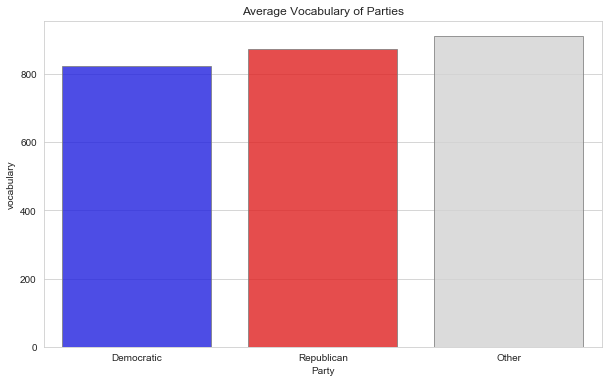

In [25]:
par=df_text.groupby('party').mean().sort_values('vocab2')
d = {'Democratic': 'blue', 'Republican': 'red', 'Other':'lightgrey'}
clrs=[d.get(x, 'idle') for x in par.index]
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
plt.title('Average Vocabulary of Parties')
sns.barplot(par.index,par.vocab2,palette=clrs,alpha=0.8,saturation=0.75,edgecolor='grey')
plt.xlabel('Party')
plt.ylabel('vocabulary')
plt.show()

Out of Democratic and Republican parties, Republicans have better vocabulary. Presidents from other parties top the list.

# What does the presidential vocabulary from the earliest president (Washington) to the latest (Trump) look like?

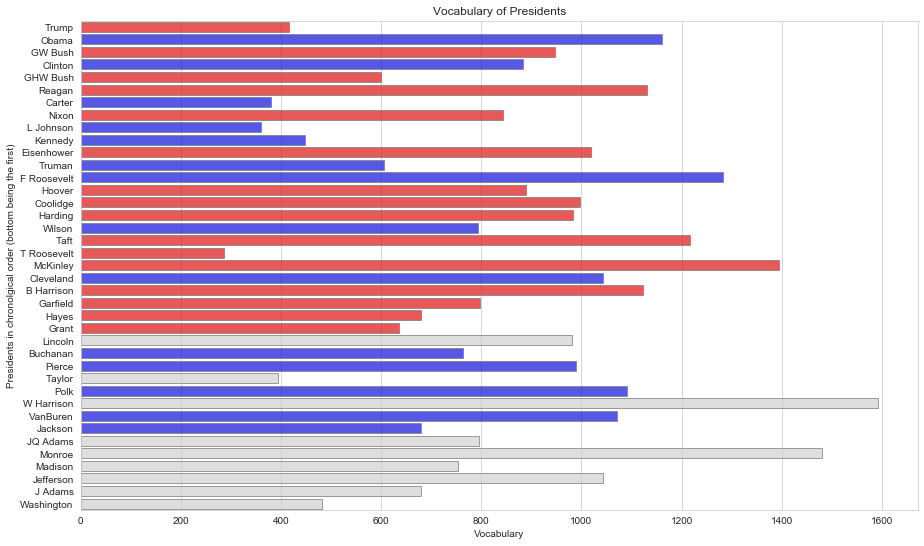

In [26]:
d = {'Democratic': 'blue', 'Republican': 'red', 'Other':'lightgrey'}
clrs=[d[x] for x in list(df_text.sort_values('year',ascending=False).party.values)]
plt.figure(figsize=(15,9))
sns.set_style('whitegrid')
plt.title('Vocabulary of Presidents')
splot=sns.barplot(y='president',x='vocab2',data=df_text.sort_values('year',ascending=False),
                  palette=clrs,alpha=0.75,saturation=0.75,edgecolor='grey')
plt.ylabel('Presidents in chronolgical order (bottom being the first)')
plt.xlabel('Vocabulary')
plt.show()

# What are the 5 most used words (by each president)?

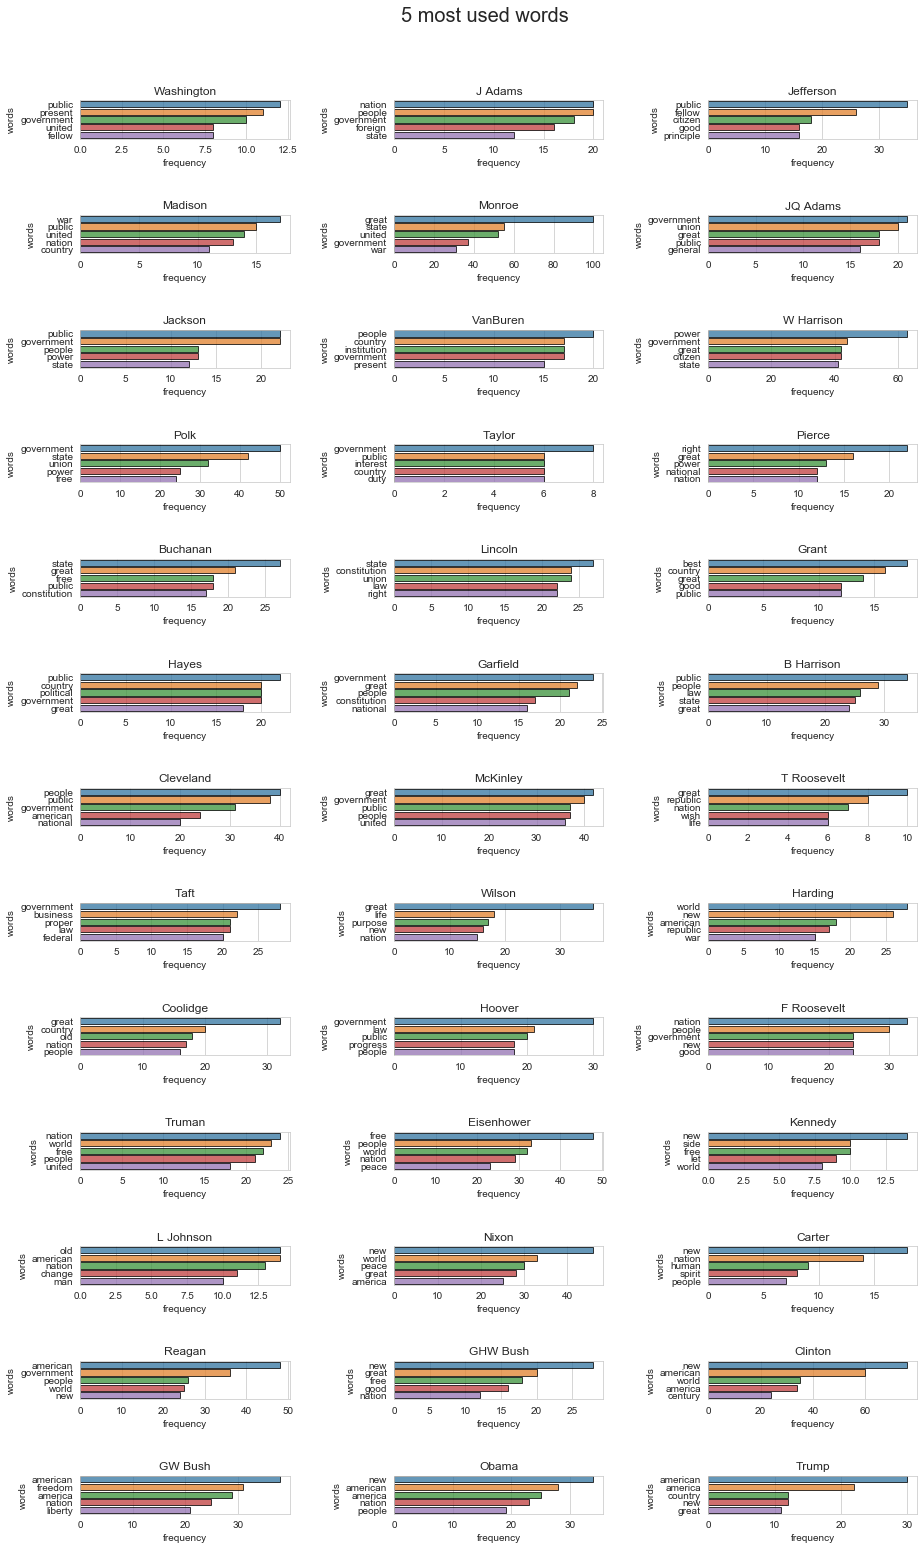

In [27]:
pres=np.reshape(list(df_text.president),(13,3))
fig, ax = plt.subplots(figsize=(15,26), ncols=3, nrows=13,squeeze=False)
plt.subplots_adjust(
    wspace  =  0.5, 
    hspace  =  2
)
y_title_margin = 1
plt.suptitle("5 most used words", y = 0.93, fontsize=20)
sns.set_style('white')

for i in range(13):
    for j in range(3):
        data=pd.Series(df_text[df_text['president']==pres[i][j]].navtext.values[0].split()).value_counts()[:5].to_frame().reset_index()
        data['frequency']=data[0]
        data['words']=data['index']
        ax[i][j].set_title(pres[i][j],y = y_title_margin)
        sns.barplot(x=data['frequency'],
                   y=data['words'],
                   data=data,
                   ax=ax[i][j],alpha=0.75,
                saturation=0.75,edgecolor='black')

The graph above shows the 5 most used words by the american presidents. "America"/"American" gained importance from the era of President Harding. It is one of the most used words by a president since President Reagan.
It is also interesting to see that "Freedom" did not make it in the top 5 words of the first few presidents, but George H.W Bush and George W Bush used it a lot.
President Obama and President Trump similar top 3 words.

# Sentiment Analysis

In [28]:
sentimentdf=pd.read_csv('presidentsentiment.csv')
sentimentdf.drop('Unnamed: 0',1,inplace=True)
sentimentdf.head()

,year,president,speech,party
0,1789,Washington,Fellow - Citizens of the Senate and of the Hou...,Other
1,1793,Washington,"Fellow citizens , I am again called upon by th...",Other
2,1797,J Adams,"When it was first perceived , in early times ,...",Other
3,1801,Jefferson,Friends and Fellow Citizens : Called upon to u...,Other
4,1805,Jefferson,"Proceeding , fellow citizens , to that qualifi...",Other


In [29]:
from textblob import TextBlob
sentiment,polarity = [],[]
polarity_a = [0]*len(sentimentdf.speech)
len(polarity)
for i, xtext in enumerate(list(sentimentdf.speech)):
    for char in '!#$%&@?,.:;+-*/=<>"\'()[\\]X{|}~\n\t':
        s = xtext.replace(char, ' ')
        #tokenizing and removing stopwords
        x=[w for w in nltk.tokenize.word_tokenize(s.lower()) if w not in stop_words]
        x=[w for w in x if w not in ['u','U']]
        xtext=' '.join(x)
    xtext = xtext.strip(punctuation).lower()
    blob=TextBlob(xtext)
    polarity.append(blob.sentiment[0])
    sentiment.append(analyzer.polarity_scores(xtext))
    polarity_a[i] = sentiment[i]['compound']
sentimentdf['polarityblob']=polarity
sentimentdf['polarityvader']=polarity_a
sentimentdf['polarity']=(sentimentdf['polarityblob']+sentimentdf['polarityvader'])/2

In [30]:
data=pd.merge(sentimentdf.groupby('president').mean().sort_values('year'),sentimentdf.drop('speech',1),
         on='president',how='left')
data.columns
data.drop(['year_y', 'polarityblob_y',
       'polarityvader_y', 'polarity_y'],1,inplace=True)
data.drop_duplicates(inplace=True)
data.sort_values('year_x')
data.head()

,president,year_x,polarityblob_x,polarityvader_x,polarity_x,party
0,Washington,1791,0.093103,0.78580,0.439451,Other
2,J Adams,1797,0.159947,0.99990,0.579923,Other
3,Jefferson,1803,0.173689,0.99980,0.586744,Other
5,Madison,1811,0.135035,0.94955,0.542292,Other
7,Monroe,1819,0.230216,0.99995,0.615083,Other


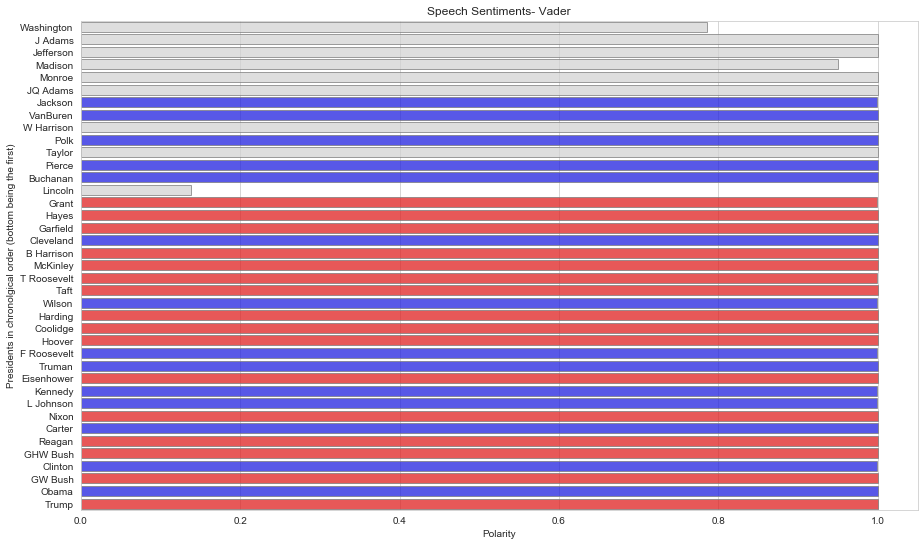

In [31]:
d = {'Democratic': 'blue', 'Republican': 'red', 'Other':'lightgrey'}
clrs=[d[x] for x in list(data.party)]
plt.figure(figsize=(15,9))
sns.set_style('whitegrid')
plt.title('Speech Sentiments- Vader')
splot=sns.barplot(y=data.president,x='polarityvader_x',data=data,
                  palette=clrs,alpha=0.75,saturation=0.75,edgecolor='grey')
plt.ylabel('Presidents in chronolgical order (bottom being the first)')
plt.xlabel('Polarity')
plt.show()

In [32]:
#Washington's first speech
df_text.speech_x[0][:500]

'Fellow - Citizens of the Senate and of the House of Representatives : Among the vicissitudes incident to life no event could have filled me with greater anxieties than that of which the notification was transmitted by your order , and received on the 14th day of the present month . On the one hand , I was summoned by my Country , whose voice I can never hear but with veneration and love , from a retreat which I had chosen with the fondest predilection , and , in my flattering hopes , with an imm'

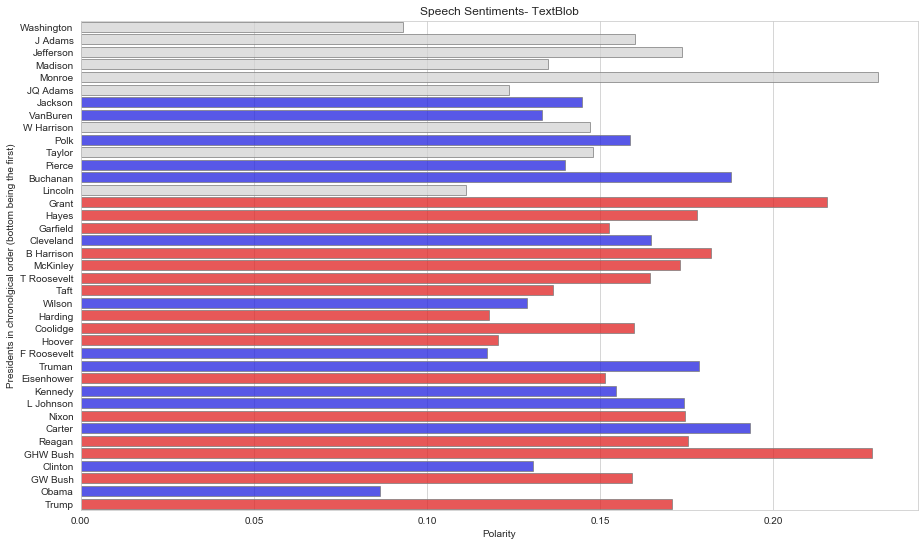

In [33]:
plt.figure(figsize=(15,9))
sns.set_style('whitegrid')
plt.title('Speech Sentiments- TextBlob')
splot=sns.barplot(y=data.president,x='polarityblob_x',data=data,
                  palette=clrs,alpha=0.75,saturation=0.75,edgecolor='grey')
plt.ylabel('Presidents in chronolgical order (bottom being the first)')
plt.xlabel('Polarity')
plt.show()

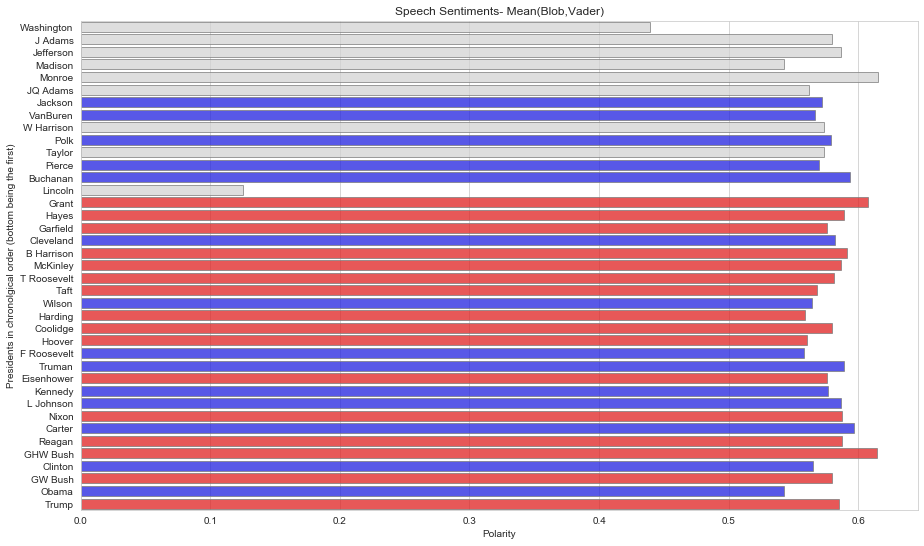

In [34]:
plt.figure(figsize=(15,9))
sns.set_style('whitegrid')
plt.title('Speech Sentiments- Mean(Blob,Vader)')
splot=sns.barplot(y=data.president,x='polarity_x',data=data,
                  palette=clrs,alpha=0.75,saturation=0.75,edgecolor='grey')
plt.ylabel('Presidents in chronolgical order (bottom being the first)')
plt.xlabel('Polarity')
plt.show()

Looking at the speeches, they were mostly positive in nature, but a polarity score of 1 is outrageous from vader. After trying textblob's sentiment analysis, I found that even though all the polarities were mildly positive, It still didn't reflect the correct sentiment of the speeches. In the end, I used my judgement and took a mean of both the polarity scores to come up with something belieavable/ reasonable.

# Party wise sentiment analysis

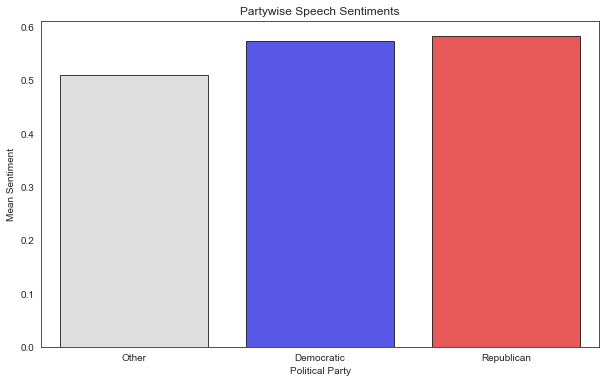

        party  polarity_x
0       Other    0.510859
1  Democratic    0.574527
2  Republican    0.582995


In [35]:
data1=data.groupby('party').mean()['polarity_x'].sort_values().to_frame().reset_index()
clrs1=[d[x] for x in data1.party]
plt.figure(figsize=(10,6))
sns.set_style('white')
plt.title('Partywise Speech Sentiments')
sns.barplot(y=data1.polarity_x,x=data1.party,data=data1,
                  palette=clrs1,alpha=0.75,saturation=0.75,edgecolor='black')
plt.ylabel('Mean Sentiment')
plt.xlabel('Political Party')
plt.show()
print(data1)

If we compare the political parties, Republican presidents have a better mean polarity score of 0.583 when compared to others.

# Top 3 presidents with highest positive sentiment scores in each Party

In [36]:
rep=data[data.party=='Republican'].sort_values('polarity_x',ascending=False).head(3)[['president','polarity_x']]
dem=data[data.party=='Democratic'].sort_values('polarity_x',ascending=False).head(3)[['president','polarity_x']]
oth=data[data.party=='Other'].sort_values('polarity_x',ascending=False).head(3)[['president','polarity_x']]

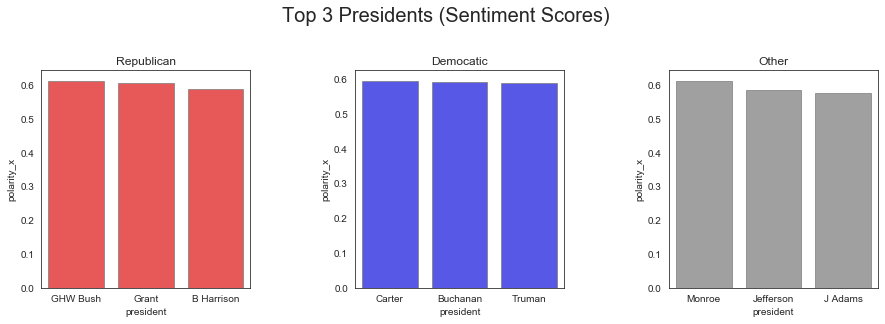

In [37]:
fig, ax = plt.subplots(figsize=(15,4), ncols=3, nrows=1,squeeze=False)
plt.subplots_adjust(
    wspace  =  0.5, 
    hspace  =  0.5
)
y_title_margin = 1.0

plt.suptitle("Top 3 Presidents (Sentiment Scores)", y = 1.1, fontsize=20)

ax[0][0].set_title("Republican",y = y_title_margin)
ax[0][1].set_title("Democatic",y = y_title_margin)
ax[0][2].set_title("Other",y = y_title_margin)

sns.barplot(x='president',
            y='polarity_x',data=rep, ax=ax[0][0],alpha=0.75,
            saturation=0.75,edgecolor='grey',color='red')
sns.barplot(x='president',
            y='polarity_x',data=dem, ax=ax[0][1],alpha=0.75,
            saturation=0.75,edgecolor='grey',color='blue')
sns.barplot(x='president',
            y='polarity_x',data=oth, ax=ax[0][2],alpha=0.75,
            saturation=0.75,edgecolor='grey',color='grey')
plt.show()

Republicans:

1. GHW Bush
2. Grant
3. B Harrison

Democrats:

1. Carter
2. Buschanan
3. Trump

Other:

1. Monroe
2. Jefferson
3. J Adams